<a href="https://colab.research.google.com/github/luther-exe/Explainable-Federated-Learning-for-Breast-Cancer-Diagnosis/blob/main/XFL_breast_cancer_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet tensorflow==2.14.0 tensorflow_federated==0.71.0
#Restart runtime after installing tensorflow and tensorflow federated before proceeding!!!

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 46.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 428, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

4/4 [==============================] - 0s 4ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

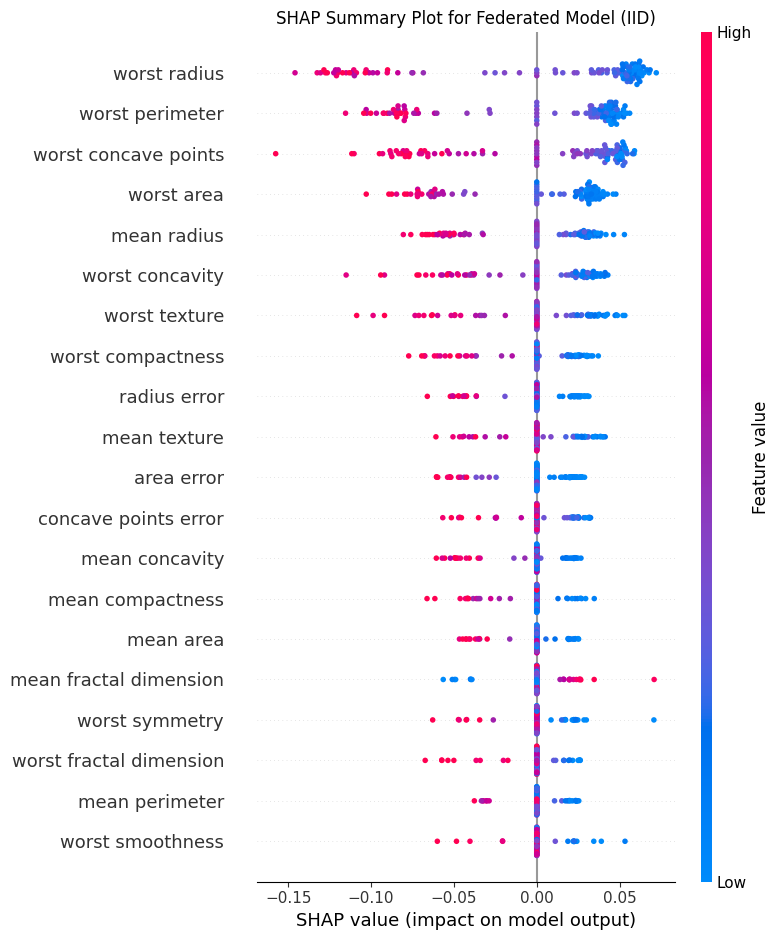

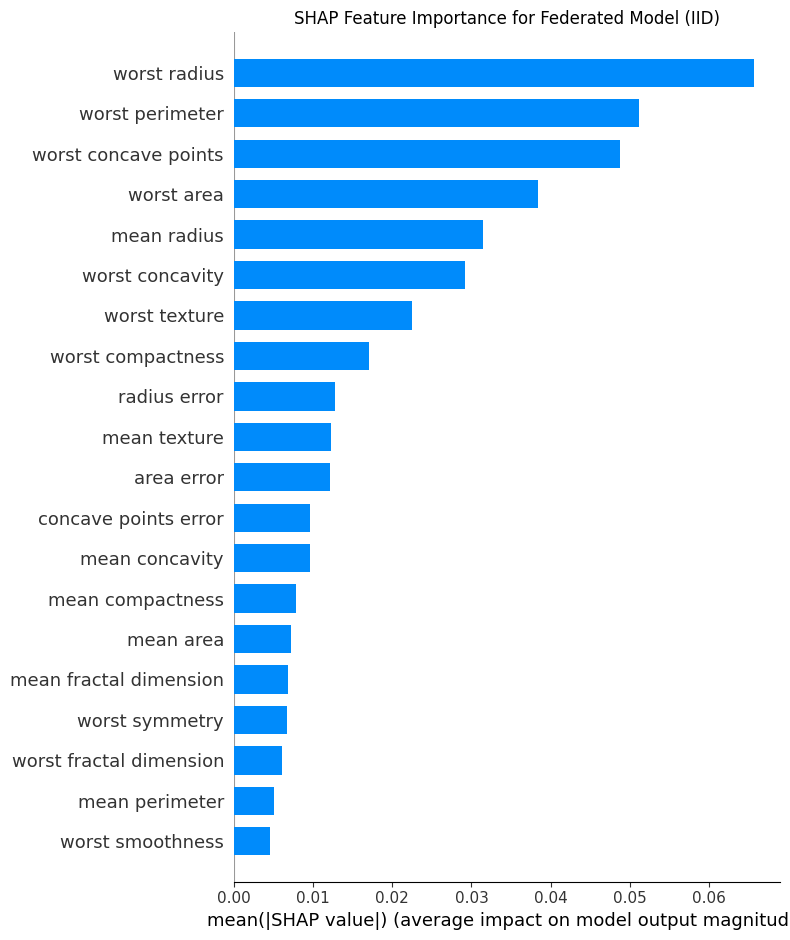

  0%|          | 0/100 [00:00<?, ?it/s]

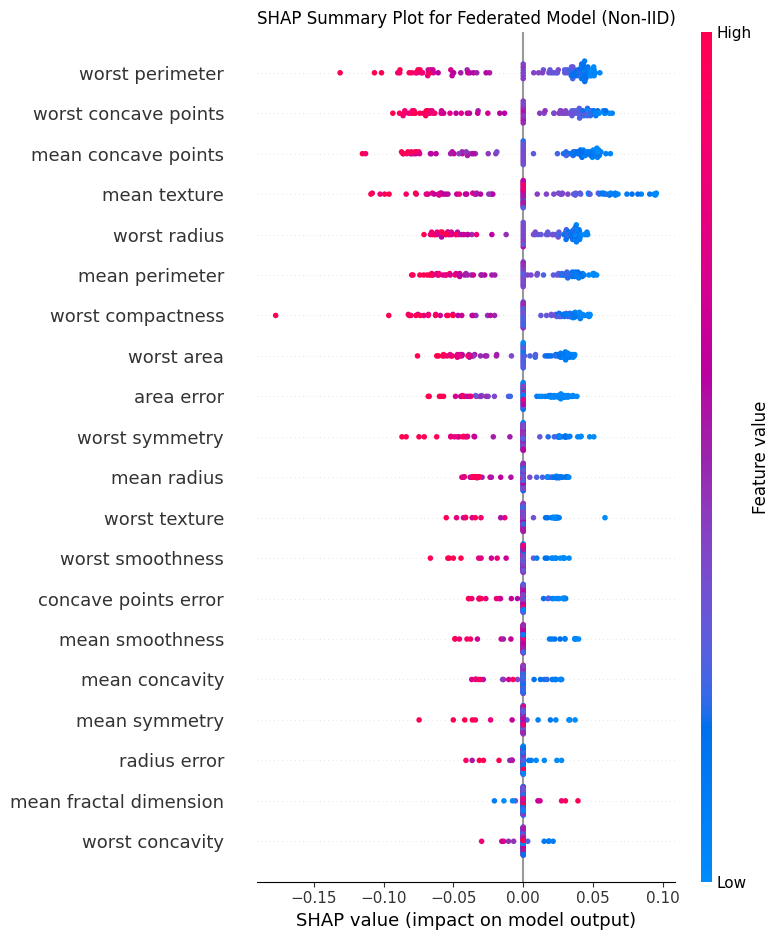

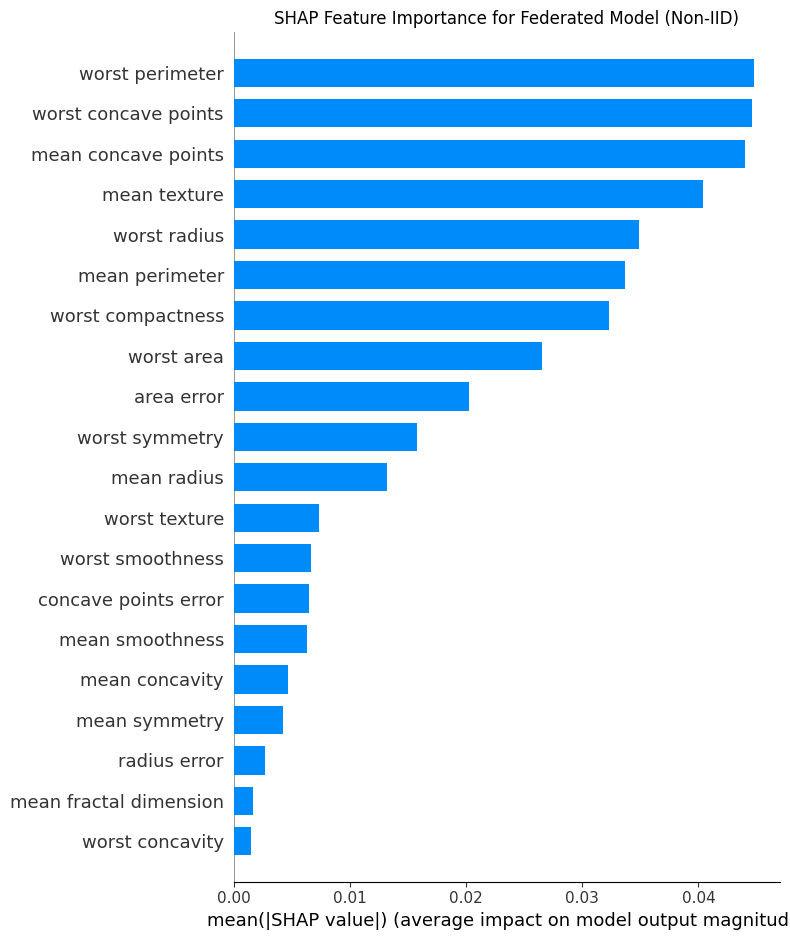

  0%|          | 0/100 [00:00<?, ?it/s]

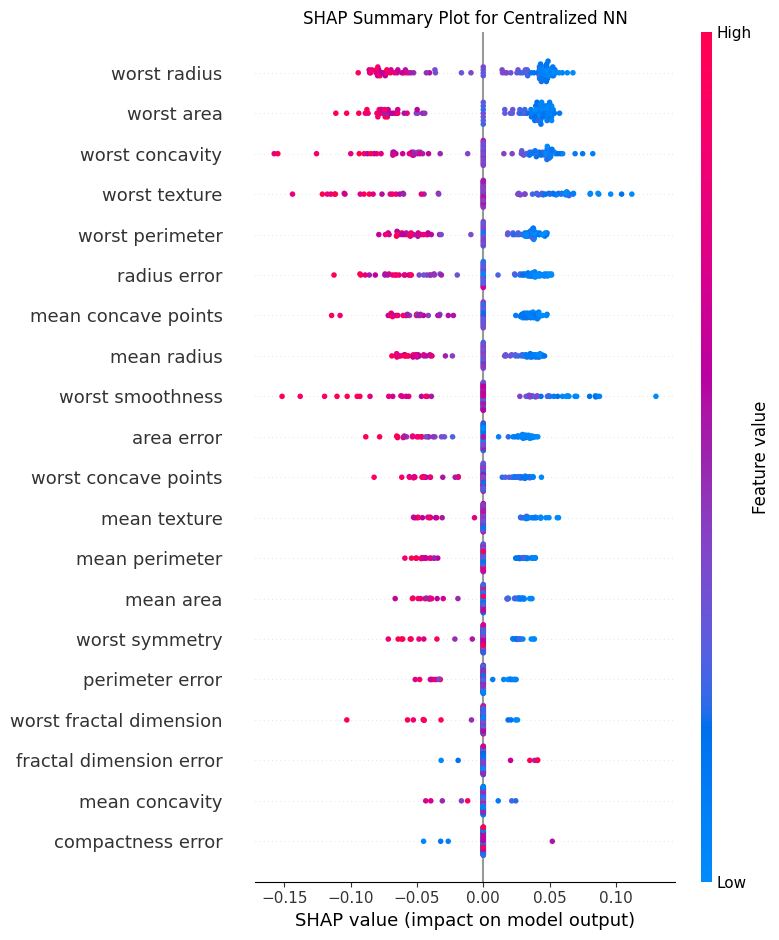

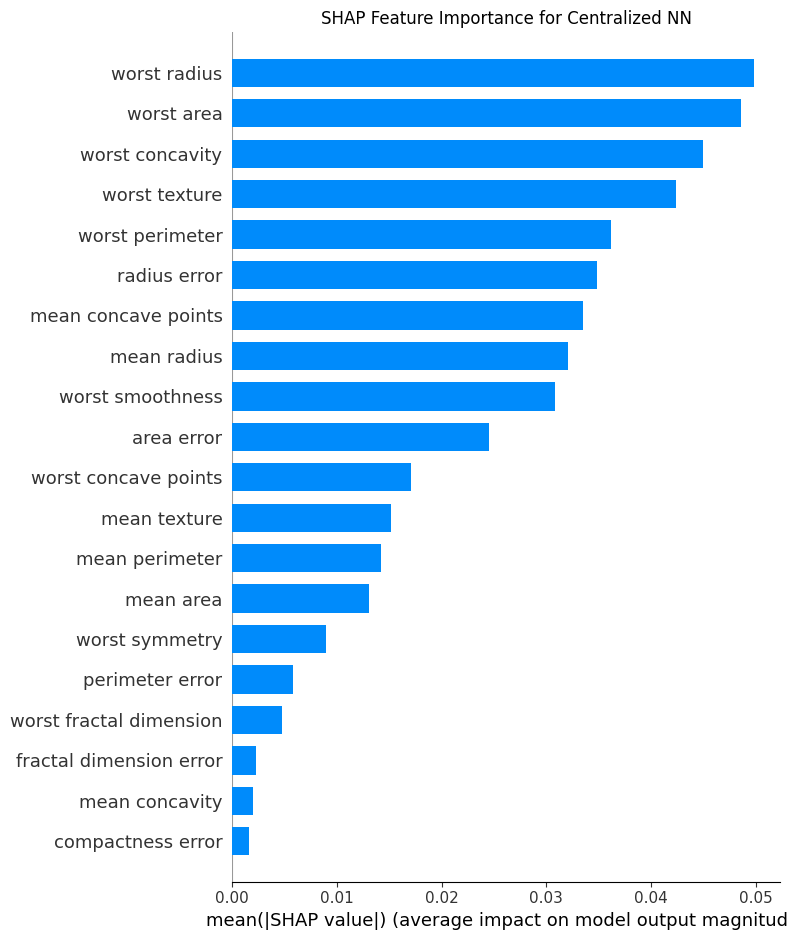


SHAP Force Plots for Federated NN (IID) (Individual Instances):

Instance 26:



Instance 79:



Instance 51:



Instance 32:



Instance 44:


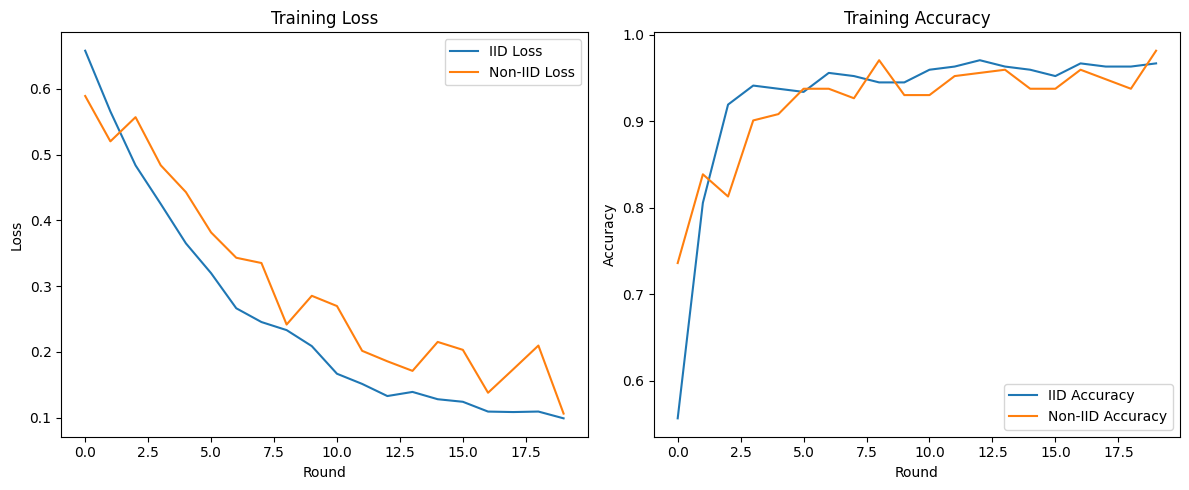

Training Curves:


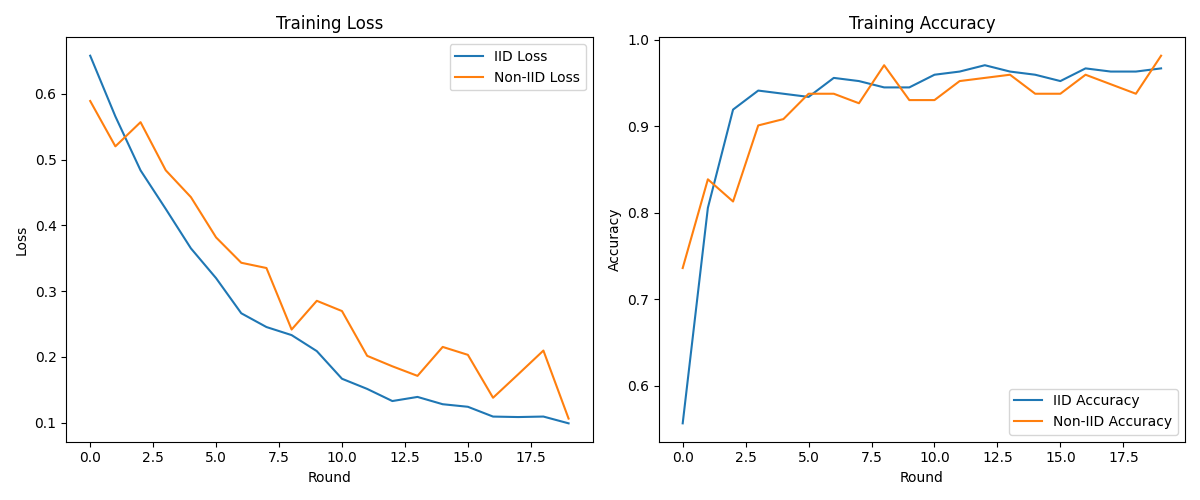

In [ ]:
import sys
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import logging
import os
from IPython.display import Image

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed=42):
    rng = np.random.default_rng(seed)
    tf.random.set_seed(seed)
    import random
    random.seed(seed)
    return rng

# Load and preprocess data
def load_and_preprocess_data():
    logging.info("Loading breast cancer dataset...")
    try:
        data = load_breast_cancer()
        X = data.data
        y = data.target
        if X.shape[1] != 30:
            raise ValueError(f"Expected 30 features, got {X.shape[1]}")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        logging.info("Data scaled. Feature names: %s", data.feature_names)
        return X_scaled, y, scaler, data.feature_names
    except ValueError as ve:
        logging.error("ValueError in load_and_preprocess_data: %s", ve)
        raise
    except Exception as e:
        logging.error("Unexpected error in load_and_preprocess_data: %s", e)
        raise

# Create IID and Non-IID partitions
def create_data_partitions(X, y, num_clients=5, non_iid=False, rng=None):
    logging.info("Creating data partitions...")
    try:
        if num_clients <= 0:
            raise ValueError("num_clients must be positive")
        if len(X) != len(y):
            raise ValueError("X and y must have the same length")
        if non_iid:
            sorted_indices = np.argsort(X[:, 0])
            X, y = X[sorted_indices], y[sorted_indices]
            client_data = []
            split_size = len(X) // num_clients
            for i in range(num_clients):
                start_idx = i * split_size
                end_idx = (i + 1) * split_size if i < num_clients - 1 else len(X)
                client_data.append((X[start_idx:end_idx], y[start_idx:end_idx]))
        else:
            indices = rng.permutation(len(X))
            X, y = X[indices] , y[indices]
            client_data = []
            split_size = len(X) // num_clients
            for i in range(num_clients):
                start_idx = i * split_size
                end_idx = (i + 1) * split_size if i < num_clients - 1 else len(X)
                client_data.append((X[start_idx:end_idx], y[start_idx:end_idx]))
        logging.info("Partitions created.")
        return client_data
    except ValueError as ve:
        logging.error("ValueError in create_data_partitions: %s", ve)
        raise
    except Exception as e:
        logging.error("Unexpected error in create_data_partitions: %s", e)
        raise

# Convert client data to TFF-compatible datasets
def create_tff_datasets(client_data, batch_size=32):
    logging.info("Converting to TFF datasets...")
    try:
        def create_tf_dataset(X, y):
            X = X.astype(np.float32)
            y = y.astype(np.int32)
            dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
            return dataset
        datasets = [create_tf_dataset(X, y) for X, y in client_data]
        for i, ds in enumerate(datasets):
            for batch in ds.take(1):
                logging.info("Client %d dataset batch shape: features=%s, labels=%s", i+1, batch[0].shape, batch[1].shape)
        logging.info("TFF datasets created.")
        return datasets
    except Exception as e:
        logging.error("Error in create_tff_datasets: %s", e)
        raise

# Define neural network model
def create_model():
    logging.info("Creating model...")
    try:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(30,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        logging.info("Model created.")
        return model
    except Exception as e:
        logging.error("Error in create_model: %s", e)
        raise

# TFF model function
def model_fn():
    logging.info("Creating TFF model...")
    try:
        keras_model = create_model()
        input_spec = tff.types.StructWithPythonType(
            (
                tff.types.TensorType(dtype=np.float32, shape=[None, 30]),
                tff.types.TensorType(dtype=np.int32, shape=[None])
            ),
            container_type=tuple
        )
        model = tff.learning.models.from_keras_model(
            keras_model=keras_model,
            input_spec=input_spec,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
        )
        logging.info("TFF model created.")
        return model
    except Exception as e:
        logging.error("Error in model_fn: %s", e)
        raise

# Training function for federated learning
def federated_training(client_datasets, num_rounds=20, clients_per_round=3, rng=None):
    logging.info("Starting federated training...")
    try:
        iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
            model_fn,
            client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
            server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0)
        )
        state = iterative_process.initialize()
        metrics_history = {'loss': [], 'accuracy': []}
        for round_num in range(num_rounds):
            sampled_clients = rng.choice(len(client_datasets), clients_per_round, replace=False)
            sampled_datasets = [client_datasets[i] for i in sampled_clients]
            state, metrics = iterative_process.next(state, sampled_datasets)
            logging.info("Round %d: loss=%.4f, accuracy=%.4f",
                         round_num + 1,
                         metrics['client_work']['train']['loss'],
                         metrics['client_work']['train']['binary_accuracy'])
            metrics_history['loss'].append(metrics['client_work']['train']['loss'])
            metrics_history['accuracy'].append(metrics['client_work']['train']['binary_accuracy'])
        logging.info("Federated training completed.")
        return state, metrics_history
    except Exception as e:
        logging.error("Error in federated_training: %s", e)
        raise

# Apply global model weights to a Keras model
def apply_global_weights(state, keras_model):
    logging.info("Applying global weights...")
    try:
        model_weights = tff.learning.models.ModelWeights(
            trainable=state.global_model_weights.trainable,
            non_trainable=state.global_model_weights.non_trainable
        )
        keras_model.set_weights(model_weights.trainable)
        logging.info("Global weights applied.")
        return keras_model
    except Exception as e:
        logging.error("Error in apply_global_weights: %s", e)
        raise

# Personalized federated learning
def personalized_federated_learning(state, client_datasets, num_epochs=2):
    logging.info("Starting personalized federated learning...")
    try:
        global_model = create_model()
        global_model = apply_global_weights(state, global_model)
        personalized_models = []
        for client_data in client_datasets:
            model = create_model()
            model.set_weights(global_model.get_weights())
            model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])
            X = []
            y = []
            for batch_x, batch_y in client_data.as_numpy_iterator():
                X.append(batch_x)
                y.append(batch_y)
            X = np.concatenate(X, axis=0)
            y = np.concatenate(y, axis=0)
            model.fit(X, y, epochs=num_epochs, verbose=0)
            personalized_models.append(model)
        logging.info("Personalized federated learning completed.")
        return personalized_models
    except Exception as e:
        logging.error("Error in personalized_federated_learning: %s", e)
        raise

# Centralized and baseline models
def train_centralized_model(X, y):
    logging.info("Training centralized NN...")
    try:
        model = create_model()
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
        history = model.fit(X, y, epochs=20, batch_size=32, verbose=0)
        logging.info("Centralized NN trained.")
        return model, history
    except Exception as e:
        logging.error("Error in train_centralized_model: %s", e)
        raise

def train_random_forest(X, y):
    logging.info("Training Random Forest...")
    try:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X, y)
        logging.info("Random Forest trained.")
        return model
    except Exception as e:
        logging.error("Error in train_random_forest: %s", e)
        raise

def train_local_models(client_data):
    logging.info("Training local-only models...")
    try:
        models = []
        for X, y in client_data:
            model = create_model()
            model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])
            model.fit(X, y, epochs=20, batch_size=32, verbose=0)
            models.append(model)
        logging.info("Local-only models trained.")
        return models
    except Exception as e:
        logging.error("Error in train_local_models: %s", e)
        raise

def evaluate_model(model, X, y, model_type='nn'):
    logging.info("Evaluating %s model...", model_type)
    try:
        if model_type == 'rf':
            y_pred = model.predict(X)
        else:
            y_pred = (model.predict(X) > 0.5).astype(int).flatten()
        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'confusion_matrix': confusion_matrix(y, y_pred)
        }
        logging.info("Evaluation completed for %s.", model_type)
        return metrics
    except Exception as e:
        logging.error("Error in evaluate_model: %s", e)
        raise

# SHAP explanation function
def compute_shap_explanations(model, X, model_type='nn', feature_names=None, subset_size=100, rng=None):
    logging.info("Computing SHAP explanations for %s...", model_type)
    try:
        if X.shape[1] != 30:
            raise ValueError(f"Expected 30 features in X, got {X.shape[1]}")
        X_subset = X[rng.choice(X.shape[0], min(subset_size, X.shape[0]), replace=False)]
        logging.info("X_subset shape: %s", X_subset.shape)

        if model_type == 'rf':
            explainer = shap.TreeExplainer(model)
            shap_values_list = explainer.shap_values(X_subset)
            shap_values = shap_values_list[1]
        else:
            # Use KernelExplainer for Keras models
            def predict_proba(inputs):
                inputs = tf.cast(inputs, tf.float32)
                return model(inputs, training=False).numpy().flatten()

            explainer = shap.KernelExplainer(predict_proba, X_subset)
            shap_values = explainer.shap_values(X_subset)

        logging.info("SHAP values shape: %s", np.array(shap_values).shape)
        if shap_values.shape[1] != 30:
            raise ValueError(f"Expected 30 features in shap_values, got {shap_values.shape[1]}")
        return shap_values, X_subset, explainer
    except Exception as e:
        logging.error("Error in compute_shap_explanations: %s", e)
        raise

# Plot SHAP summary
def plot_shap_summary(shap_values, X_subset, feature_names, model_name, save_path=None):
    logging.info("Generating SHAP summary plot for %s...", model_name)
    try:
        if len(feature_names) != 30:
            raise ValueError(f"Expected 30 feature names, got {len(feature_names)}")
        if shap_values.shape[1] != X_subset.shape[1]:
            raise ValueError(f"SHAP values shape {shap_values.shape} does not match X_subset shape {X_subset.shape}")

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_subset, feature_names=feature_names, show=False)
        plt.title(f"SHAP Summary Plot for {model_name}")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_subset, feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f"SHAP Feature Importance for {model_name}")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path.replace(".png", "_bar.png"))
        plt.show()
    except Exception as e:
        logging.error("Error in plot_shap_summary: %s", e)
        raise

# Main experiment
def main():
    rng = set_seed(42)
    logging.info("Starting main function...")
    try:
        # Load and split data
        X, y, scaler, feature_names = load_and_preprocess_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        logging.info("Data split into train/test.")

        # Create IID and Non-IID partitions
        client_data_iid = create_data_partitions(X_train, y_train, non_iid=False, rng=rng)
        client_data_non_iid = create_data_partitions(X_train, y_train, non_iid=True, rng=rng)
        client_datasets_iid = create_tff_datasets(client_data_iid)
        client_datasets_non_iid = create_tff_datasets(client_data_non_iid)
        logging.info("IID and Non-IID datasets ready.")

        # Train federated models
        logging.info("Training Federated Model (IID)...")
        state_iid, metrics_iid = federated_training(client_datasets_iid, rng=rng)
        logging.info("Training Federated Model (Non-IID)...")
        state_non_iid, metrics_non_iid = federated_training(client_datasets_non_iid, rng=rng)

        # Apply global model weights
        global_model_iid = create_model()
        global_model_iid = apply_global_weights(state_iid, global_model_iid)
        global_model_non_iid = create_model()
        global_model_non_iid = apply_global_weights(state_non_iid, global_model_non_iid)

        # Train personalized models
        logging.info("Training Personalized Models (Non-IID)...")
        personalized_models = personalized_federated_learning(state_non_iid, client_datasets_non_iid)

        # Train baseline models
        centralized_nn, centralized_nn_history = train_centralized_model(X_train, y_train)
        random_forest = train_random_forest(X_train, y_train)
        centralized_pooled_nn, centralized_pooled_nn_history = train_centralized_model(X_train, y_train)
        local_models = train_local_models(client_data_non_iid)

        # Evaluate models
        results = {}
        results['Federated NN (IID)'] = evaluate_model(global_model_iid, X_test, y_test)
        results['Federated NN (Non-IID)'] = evaluate_model(global_model_non_iid, X_test, y_test)
        results['Centralized NN'] = evaluate_model(centralized_nn, X_test, y_test)
        results['Random Forest'] = evaluate_model(random_forest, X_test, y_test, model_type='rf')
        results['Centralized Pooled NN'] = evaluate_model(centralized_pooled_nn, X_test, y_test)
        for i, model in enumerate(local_models):
            results[f'Local-Only NN {i+1}'] = evaluate_model(model, X_test, y_test)
        for i, model in enumerate(personalized_models):
            results[f'Personalized NN {i+1}'] = evaluate_model(model, X_test, y_test)

        # Print evaluation results
        for model_name, metrics in results.items():
            logging.info("\n%s:", model_name)
            logging.info("Accuracy: %.4f", metrics['accuracy'])
            logging.info("Precision: %.4f", metrics['precision'])
            logging.info("Recall: %.4f", metrics['recall'])
            logging.info("F1-Score: %.4f", metrics['f1'])
            logging.info("Confusion Matrix:\n%s", metrics['confusion_matrix'])

        # SHAP explanations for important models
        logging.info("Computing SHAP Explanations for important models...")
        shap_values_dict = {}
        X_subset_dict = {}
        explainer_dict = {}

        # Federated NN (IID)
        shap_values_global_iid, X_test_subset_iid, explainer_iid = compute_shap_explanations(
            global_model_iid, X_test, model_type='nn', feature_names=feature_names, rng=rng)
        shap_values_dict['Federated NN (IID)'] = shap_values_global_iid
        X_subset_dict['Federated NN (IID)'] = X_test_subset_iid
        explainer_dict['Federated NN (IID)'] = explainer_iid
        plot_shap_summary(shap_values_global_iid, X_test_subset_iid, feature_names,
                         "Federated Model (IID)", save_path="shap_fed_iid.png")

        # Federated NN (Non-IID)
        shap_values_global_non_iid, X_test_subset_non_iid, explainer_non_iid = compute_shap_explanations(
            global_model_non_iid, X_test, model_type='nn', feature_names=feature_names, rng=rng)
        shap_values_dict['Federated NN (Non-IID)'] = shap_values_global_non_iid
        X_subset_dict['Federated NN (Non-IID)'] = X_test_subset_non_iid
        explainer_dict['Federated NN (Non-IID)'] = explainer_non_iid
        plot_shap_summary(shap_values_global_non_iid, X_test_subset_non_iid, feature_names,
                         "Federated Model (Non-IID)", save_path="shap_fed_non_iid.png")

        # Centralized NN
        shap_values_centralized_nn, X_test_subset_centralized_nn, explainer_centralized = compute_shap_explanations(
            centralized_nn, X_test, model_type='nn', feature_names=feature_names, rng=rng)
        shap_values_dict['Centralized NN'] = shap_values_centralized_nn
        X_subset_dict['Centralized NN'] = X_test_subset_centralized_nn
        explainer_dict['Centralized NN'] = explainer_centralized
        plot_shap_summary(shap_values_centralized_nn, X_test_subset_centralized_nn, feature_names,
                         "Centralized NN", save_path="shap_centralized_nn.png")

        model_name = 'Federated NN (IID)'
        shap_values = shap_values_dict[model_name]
        X_subset = X_subset_dict[model_name]
        explainer = explainer_dict[model_name]
        feature_names = feature_names

        num_instances_to_plot = 5
        if X_subset.shape[0] >= num_instances_to_plot:
            instance_indices = rng.choice(X_subset.shape[0], num_instances_to_plot, replace=False)
        else:
            instance_indices = np.arange(X_subset.shape[0])
            print(f"Warning: Subset size is less than {num_instances_to_plot}. Plotting all {X_subset.shape[0]} instances.")


        shap.initjs()

        # Visualize SHAP explanations for each selected instance
        print(f"\nSHAP Force Plots for {model_name} (Individual Instances):")
        for i in instance_indices:
            print(f"\nInstance {i+1}:")
            display(shap.force_plot(explainer.expected_value, shap_values[i], X_subset[i], feature_names=feature_names))


        # Training curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(metrics_iid['loss'], label='IID Loss')
        plt.plot(metrics_non_iid['loss'], label='Non-IID Loss')
        plt.title('Training Loss')
        plt.xlabel('Round')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(metrics_iid['accuracy'], label='IID Accuracy')
        plt.plot(metrics_non_iid['accuracy'], label='Non-IID Accuracy')
        plt.title('Training Accuracy')
        plt.xlabel('Round')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()

        full_image_path = "/content/training_curves.png"
        plt.savefig(full_image_path)
        plt.show()

        if os.path.exists(full_image_path):
            with open(full_image_path, 'rb') as f:
                image_data = f.read()
            print("Training Curves:")
            display(Image(data=image_data))
        else:
            print(f"Error: The image file '{full_image_path}' was not found.")


        return results, metrics_iid, metrics_non_iid, feature_names, X_test, y_test, global_model_iid, global_model_non_iid, centralized_nn, random_forest, shap_values_dict, X_subset_dict, explainer_dict, centralized_nn_history

    except Exception as e:
        logging.error("Error in main: %s", e)
        raise

if __name__ == "__main__":
    logging.info("Script loaded successfully.")
    logging.info("Triggering main function...")
    results, metrics_iid, metrics_non_iid, feature_names, X_test, y_test, global_model_iid, global_model_non_iid, centralized_nn, random_forest, shap_values_dict, X_subset_dict, explainer_dict, centralized_nn_history = main()


Confusion Matrix Heatmaps:


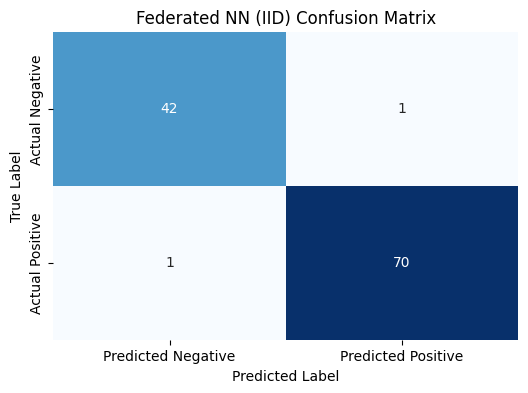

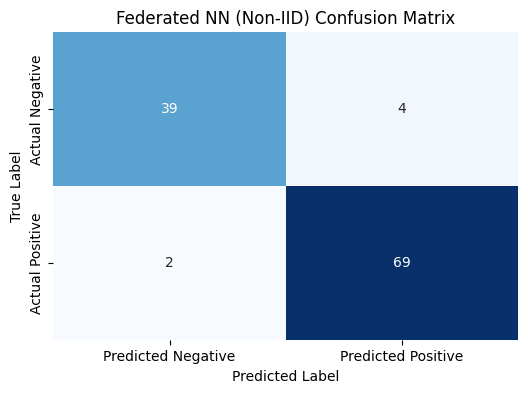

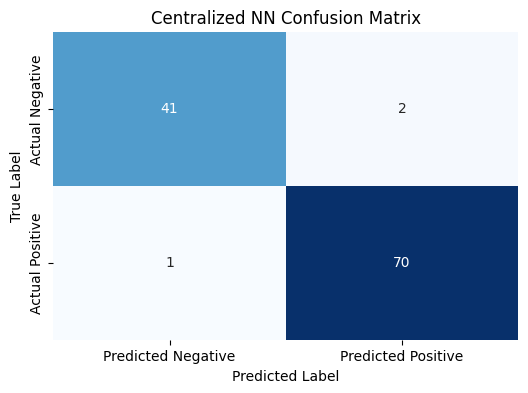

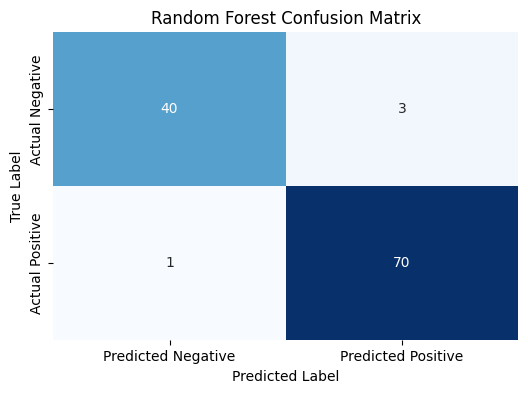

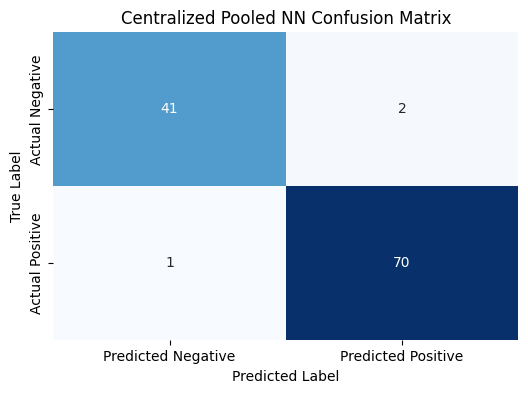

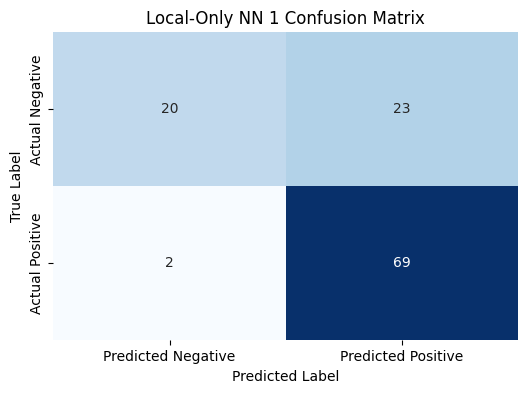

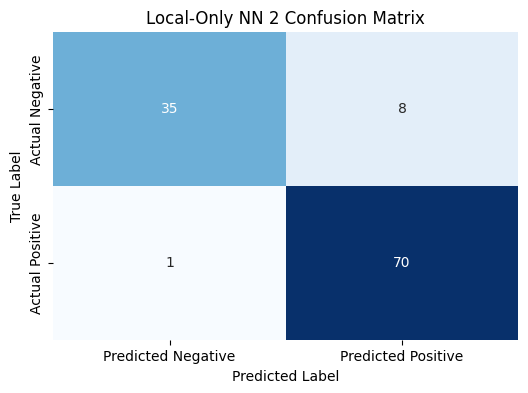

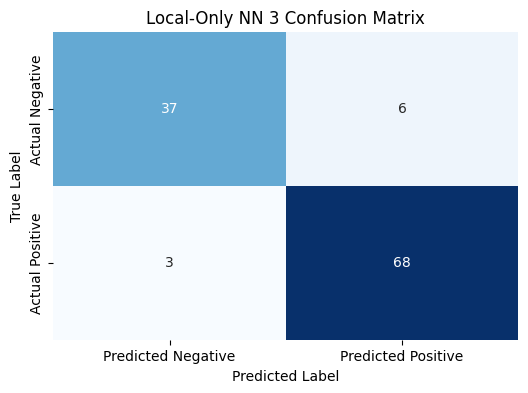

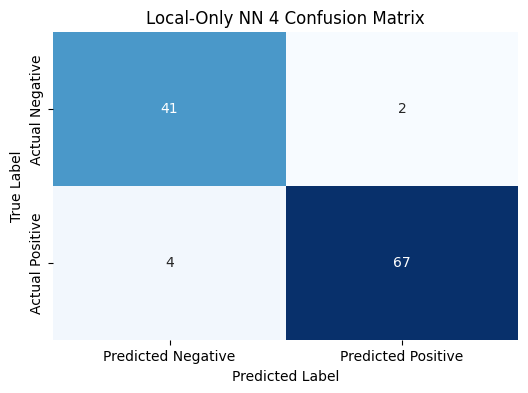

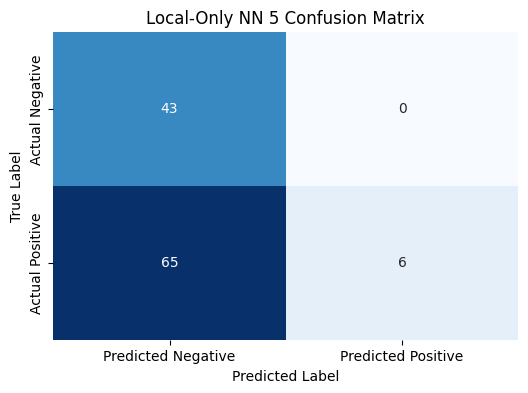

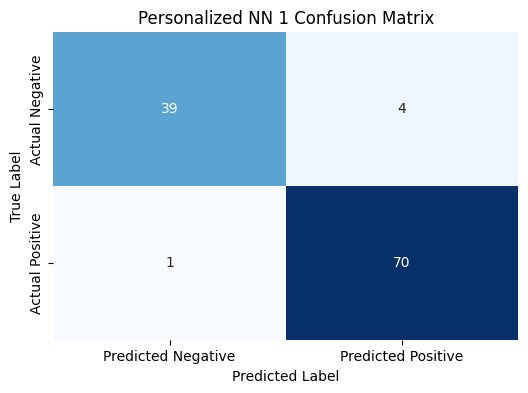

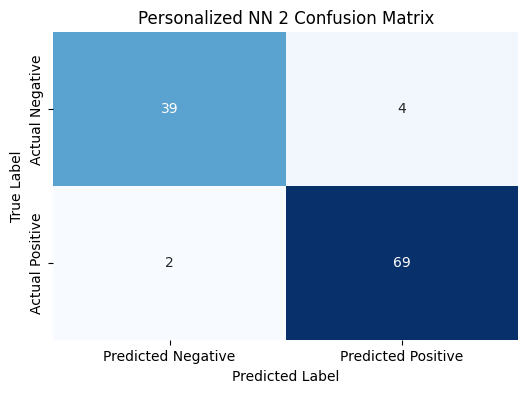

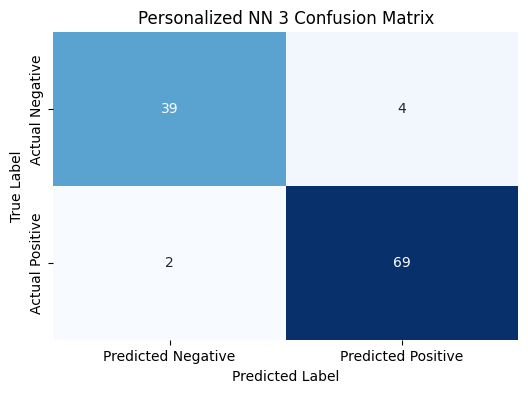

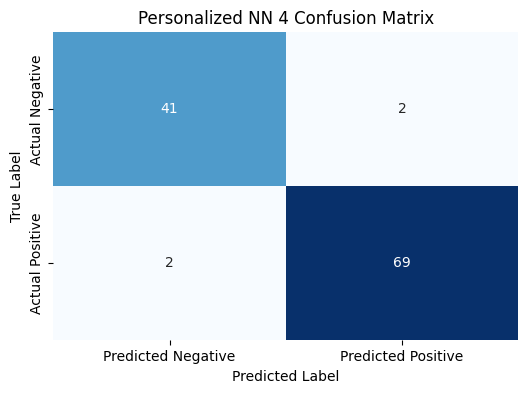

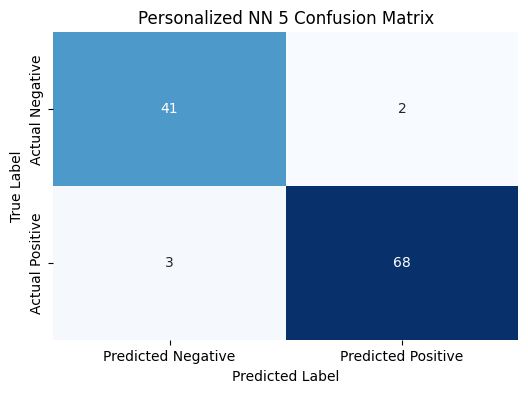

In [ ]:
# Visualize the confusion matrices
print("\nConfusion Matrix Heatmaps:")
for model_name, metrics in results.items():
    cm = metrics['confusion_matrix']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
# Display the DataFrame with performance metrics
print("\nModel Performance Metrics:")
display(results_df_display)


Model Performance Metrics:


,accuracy,precision,recall,f1
Federated NN (IID),0.982456,0.985915,0.985915,0.985915
Federated NN (Non-IID),0.947368,0.945205,0.971831,0.958333
Centralized NN,0.973684,0.972222,0.985915,0.979021
Random Forest,0.964912,0.958904,0.985915,0.972222
Centralized Pooled NN,0.973684,0.972222,0.985915,0.979021
Local-Only NN 1,0.780702,0.750000,0.971831,0.846626
Local-Only NN 2,0.921053,0.897436,0.985915,0.939597
Local-Only NN 3,0.921053,0.918919,0.957746,0.937931
Local-Only NN 4,0.947368,0.971014,0.943662,0.957143
Local-Only NN 5,0.429825,1.000000,0.084507,0.155844


Training Curves:


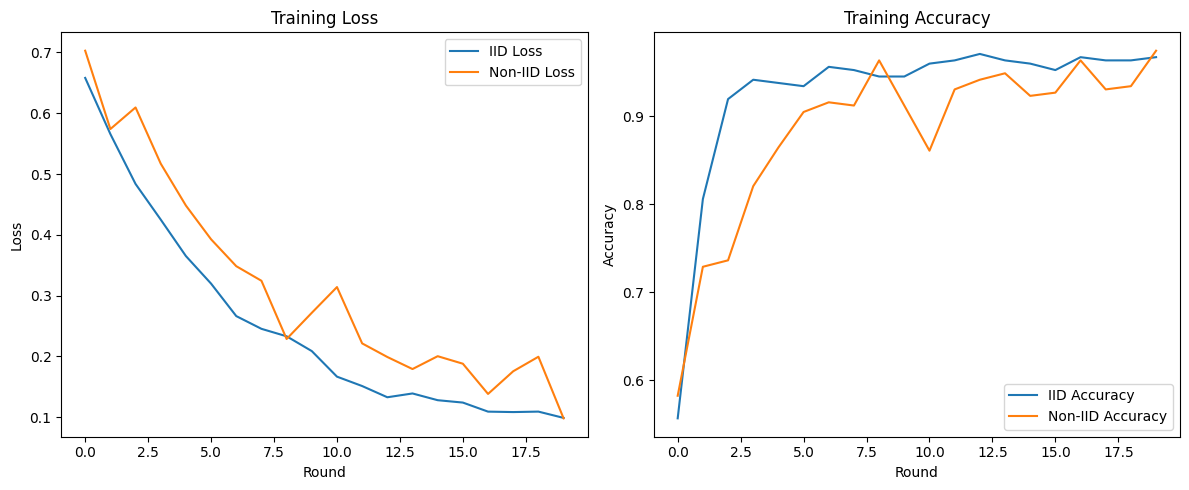


Performance Metrics Comparison:


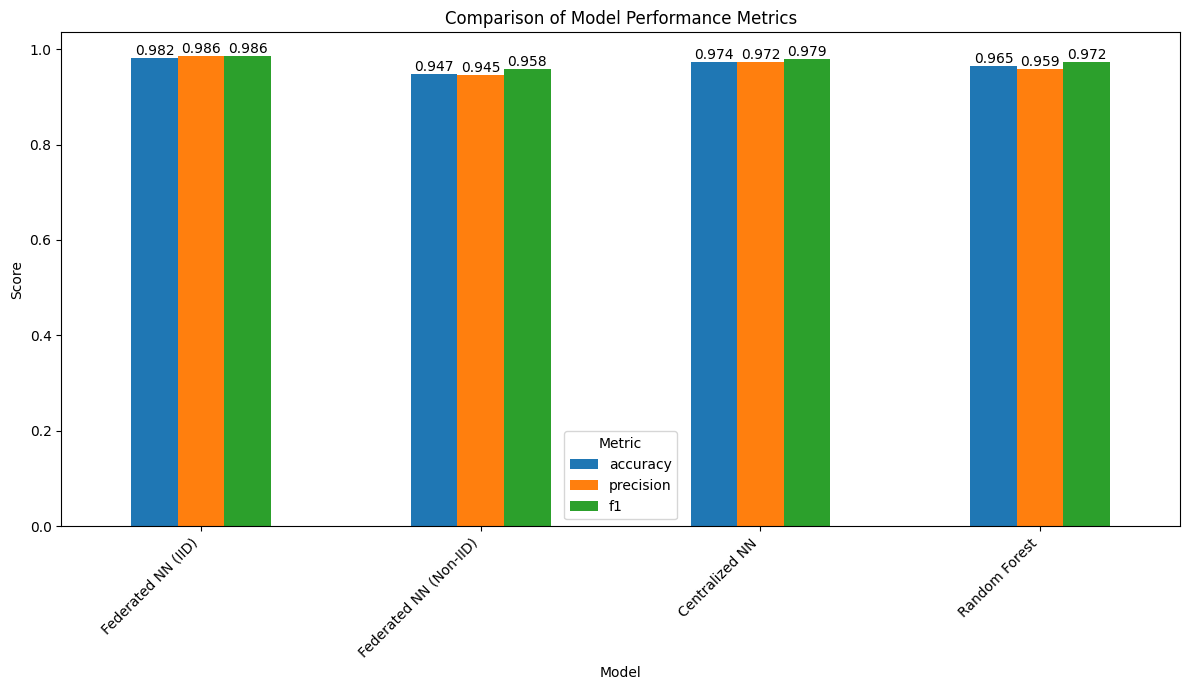

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("Training Curves:")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics_iid['loss'], label='IID Loss')
plt.plot(metrics_non_iid['loss'], label='Non-IID Loss')
plt.title('Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(metrics_iid['accuracy'], label='IID Accuracy')
plt.plot(metrics_non_iid['accuracy'], label='Non-IID Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

print("\nPerformance Metrics Comparison:")

models_to_compare = ['Federated NN (IID)', 'Federated NN (Non-IID)', 'Centralized NN', 'Random Forest']
metrics_to_plot = ['accuracy', 'precision', 'f1']

comparison_data = results_df_display.loc[models_to_compare, metrics_to_plot]

# Plotting the bar chart
ax = comparison_data.plot(kind='bar', figsize=(12, 7))
plt.title('Comparison of Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.show()

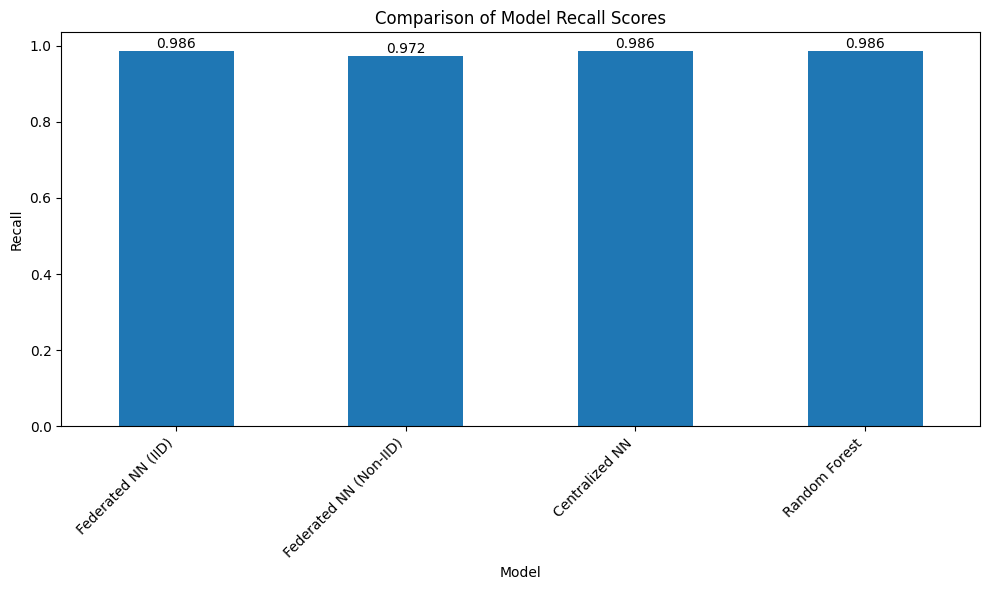

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

models_to_compare = ['Federated NN (IID)', 'Federated NN (Non-IID)', 'Centralized NN', 'Random Forest']

recall_data = results_df_display.loc[models_to_compare, ['recall']]

# Plotting the bar chart for recall
ax = recall_data.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Comparison of Model Recall Scores')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.show()

In [ ]:
import shap

# Force Plot
model_name_to_analyze = 'Federated NN (IID)'

shap_values = shap_values_dict.get(model_name_to_analyze)
X_subset = X_subset_dict.get(model_name_to_analyze)
explainer = explainer_dict.get(model_name_to_analyze)

if shap_values is None or X_subset is None or explainer is None:
    print(f"SHAP data not found for model: {model_name_to_analyze}")
else:
    num_instances_to_plot = 5
    if X_subset.shape[0] >= num_instances_to_plot:
        instance_indices = np.random.choice(X_subset.shape[0], num_instances_to_plot, replace=False)
    else:
        instance_indices = np.arange(X_subset.shape[0])
        print(f"Warning: Subset size is less than {num_instances_to_plot}. Plotting all {X_subset.shape[0]} instances.")

    shap.initjs()

    print(f"\nSHAP Force Plots for {model_name_to_analyze} (Individual Instances):")
    for i in instance_indices:
        print(f"\nInstance {i+1}:")
        display(shap.force_plot(explainer.expected_value, shap_values[i], X_subset[i], feature_names=feature_names))


SHAP Force Plots for Federated NN (IID) (Individual Instances):

Instance 90:



Instance 28:



Instance 82:



Instance 81:



Instance 8:



Generating and saving SHAP Dependence Plots for the top 5 features of Federated NN (IID):



Generating dependence plot for feature: worst radius
Plot saved to: shap_dependence_plot_Federated_NN_IID_worst_radius.png


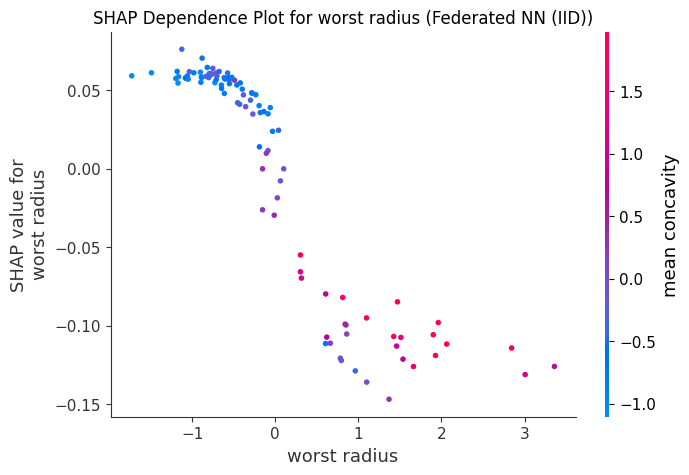


Generating dependence plot for feature: worst perimeter
Plot saved to: shap_dependence_plot_Federated_NN_IID_worst_perimeter.png


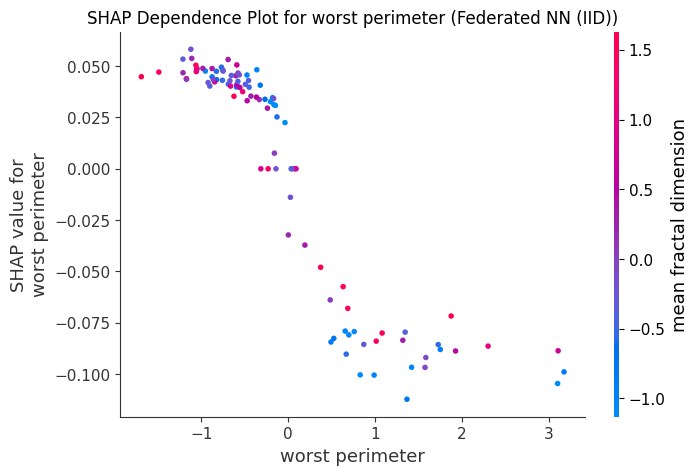


Generating dependence plot for feature: worst concave points
Plot saved to: shap_dependence_plot_Federated_NN_IID_worst_concave_points.png


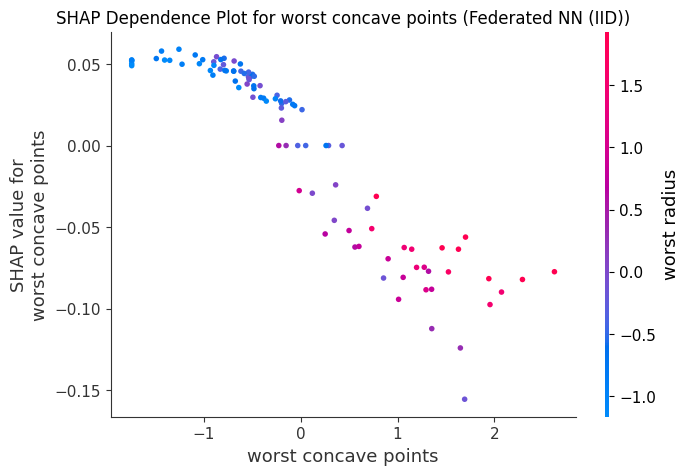


Generating dependence plot for feature: worst area
Plot saved to: shap_dependence_plot_Federated_NN_IID_worst_area.png


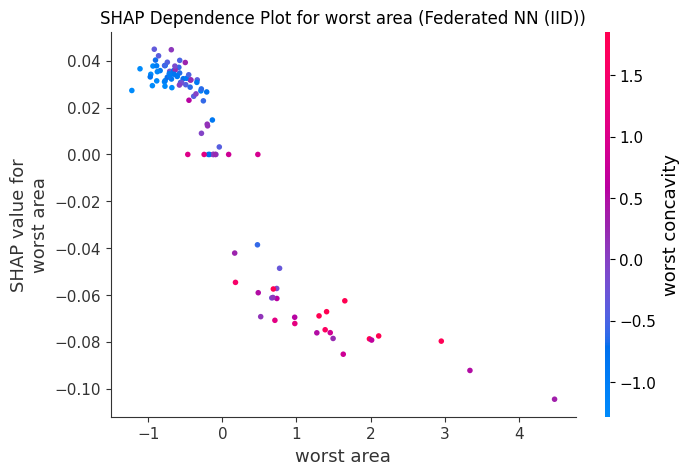


Generating dependence plot for feature: mean radius
Plot saved to: shap_dependence_plot_Federated_NN_IID_mean_radius.png


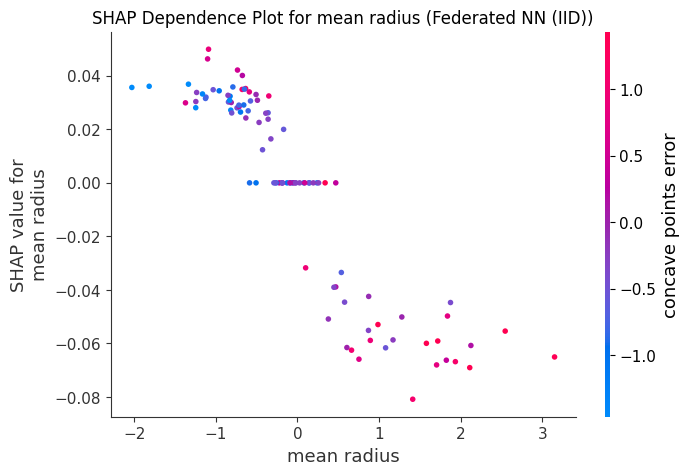

In [ ]:
# SHAP Dependence Plot
model_name_to_analyze = 'Federated NN (IID)'

shap_values = shap_values_dict.get(model_name_to_analyze)
X_subset = X_subset_dict.get(model_name_to_analyze)

if shap_values is None or X_subset is None:
    print(f"SHAP data not found for model: {model_name_to_analyze}")
else:
    mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
    sorted_feature_indices = np.argsort(mean_abs_shap_values)[::-1]

    num_top_features = 5
    top_feature_indices = sorted_feature_indices[:num_top_features]
    top_feature_names = [feature_names[i] for i in top_feature_indices]

    print(f"\nGenerating and saving SHAP Dependence Plots for the top {num_top_features} features of {model_name_to_analyze}:")

    # Generate and display dependence plots for the top features
    shap.initjs()
    for i in top_feature_indices:
        feature_name = feature_names[i].replace(" ", "_").replace("/", "_")
        plot_filename = f"shap_dependence_plot_{model_name_to_analyze.replace(' ', '_').replace('(', '').replace(')', '')}_{feature_name}.png"

        print(f"\nGenerating dependence plot for feature: {feature_names[i]}")
        shap.dependence_plot(i, shap_values, X_subset, feature_names=feature_names, show=False)
        plt.title(f'SHAP Dependence Plot for {feature_names[i]} ({model_name_to_analyze})')

        plt.savefig(plot_filename, bbox_inches='tight')
        print(f"Plot saved to: {plot_filename}")

        plt.show()

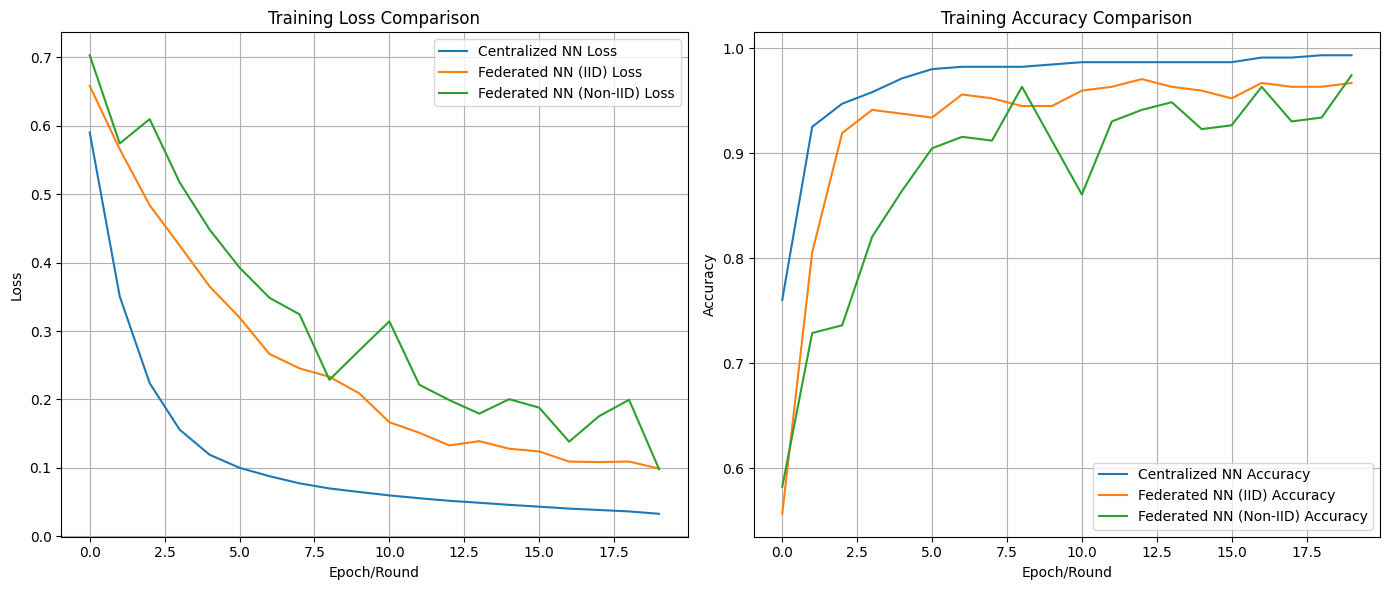

In [ ]:
import matplotlib.pyplot as plt

# Training Loss vs Accuracy graph
centralized_loss = centralized_nn_history.history['loss']
centralized_accuracy = centralized_nn_history.history['accuracy']

federated_iid_loss = metrics_iid['loss']
federated_iid_accuracy = metrics_iid['accuracy']
federated_non_iid_loss = metrics_non_iid['loss']
federated_non_iid_accuracy = metrics_non_iid['accuracy']

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(centralized_loss, label='Centralized NN Loss')
plt.plot(federated_iid_loss, label='Federated NN (IID) Loss')
plt.plot(federated_non_iid_loss, label='Federated NN (Non-IID) Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch/Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(centralized_accuracy, label='Centralized NN Accuracy')
plt.plot(federated_iid_accuracy, label='Federated NN (IID) Accuracy')
plt.plot(federated_non_iid_accuracy, label='Federated NN (Non-IID) Accuracy')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch/Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Filter the DataFrame to show only incorrect predictions
incorrect_predictions_df = prediction_results_df[prediction_results_df['Actual Label'] != prediction_results_df['Predicted Label']]

print("Instances with Incorrect Predictions (Federated NN Non-IID):")
if not incorrect_predictions_df.empty:
    display(incorrect_predictions_df)
else:
    print("No incorrect predictions found for this model on the test set.")

false_positives_df = incorrect_predictions_df[incorrect_predictions_df['Predicted Label'] == 'malignant']
false_negatives_df = incorrect_predictions_df[incorrect_predictions_df['Predicted Label'] == 'benign']

print("\nFalse Positives:")
if not false_positives_df.empty:
    display(false_positives_df)
else:
    print("No False Positives found.")

print("\nFalse Negatives:")
if not false_negatives_df.empty:
    display(false_negatives_df)
else:
    print("No False Negatives found.")

Instances with Incorrect Predictions (Federated NN Non-IID):


,Actual Label,Predicted Label,Predicted Probability (Malignant)
7,benign,malignant,0.500032
8,malignant,benign,0.491912
20,benign,malignant,0.777444
52,malignant,benign,0.369719
77,benign,malignant,0.550404
82,benign,malignant,0.587937



False Positives:


,Actual Label,Predicted Label,Predicted Probability (Malignant)
7,benign,malignant,0.500032
20,benign,malignant,0.777444
77,benign,malignant,0.550404
82,benign,malignant,0.587937



False Negatives:


,Actual Label,Predicted Label,Predicted Probability (Malignant)
8,malignant,benign,0.491912
52,malignant,benign,0.369719


In [ ]:
# Updated performance table
models_for_table = ['Centralized NN', 'Federated NN (Non-IID)', 'Federated NN (IID)', 'Random Forest']

updated_performance_table = results_df_display.loc[models_for_table, ['accuracy', 'precision', 'recall', 'f1']].copy()

updated_performance_table.loc['Personalized FL-NN (Avg)'] = average_personalized_metrics[['accuracy', 'precision', 'recall', 'f1']]
updated_performance_table.loc['Local-Only NNs (Avg)'] = average_local_only_metrics[['accuracy', 'precision', 'recall', 'f1']]

print("Updated Model Performance Metrics Table:")
display(updated_performance_table)

Updated Model Performance Metrics Table:


,accuracy,precision,recall,f1
Centralized NN,0.973684,0.972222,0.985915,0.979021
Federated NN (Non-IID),0.947368,0.945205,0.971831,0.958333
Federated NN (IID),0.982456,0.985915,0.985915,0.985915
Random Forest,0.964912,0.958904,0.985915,0.972222
Personalized FL-NN (Avg),0.954386,0.955923,0.971831,0.963711
Local-Only NNs (Avg),0.800000,0.907474,0.788732,0.767428



Confusion Matrix Heatmaps (Including Averages):


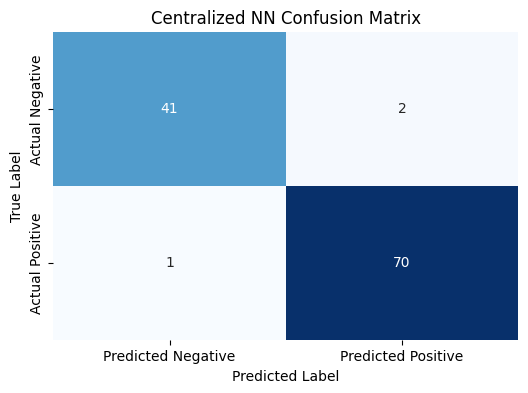

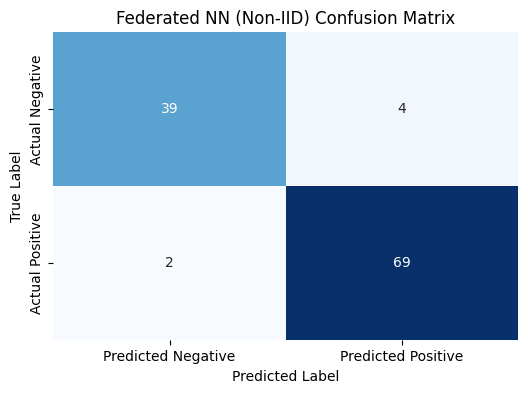

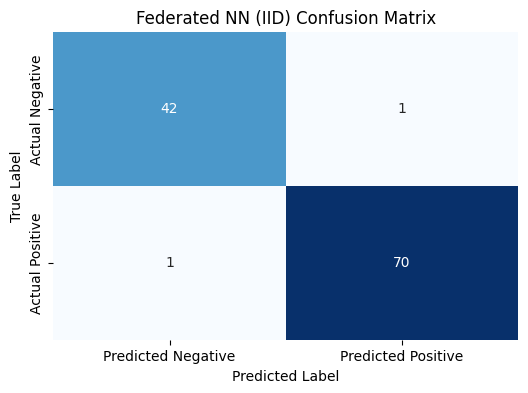

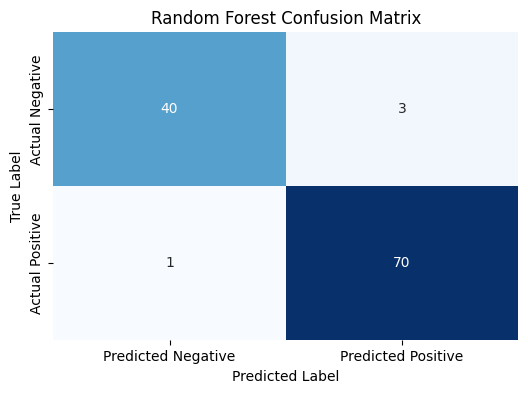

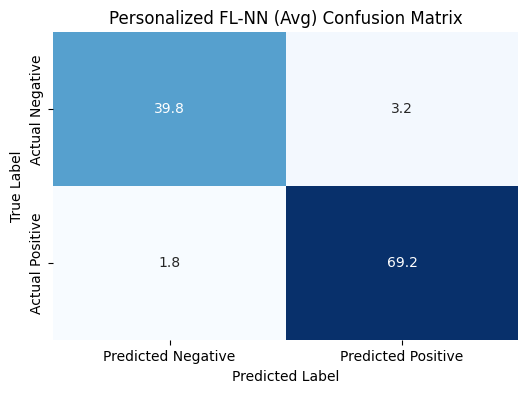

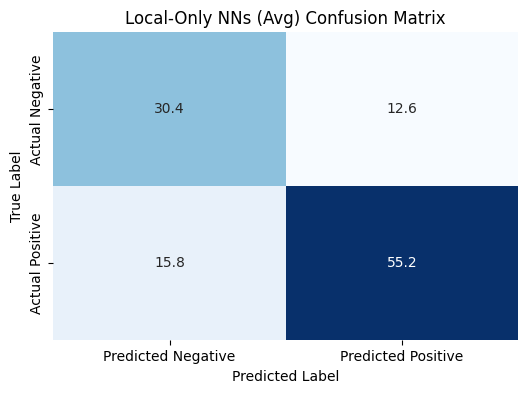

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix visualization
models_to_visualize = ['Centralized NN', 'Federated NN (Non-IID)', 'Federated NN (IID)', 'Random Forest']

print("\nConfusion Matrix Heatmaps (Including Averages):")

# Visualize confusion matrices for individual models
for model_name in models_to_visualize:
    if model_name in results and 'confusion_matrix' in results[model_name]:
        cm = results[model_name]['confusion_matrix']
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print(f"Confusion matrix data not found for {model_name}")

personalized_cms = [results[name]['confusion_matrix'] for name in results if name.startswith('Personalized NN') and 'confusion_matrix' in results[name]]
if personalized_cms:
    average_personalized_cm = np.mean(personalized_cms, axis=0)
    plt.figure(figsize=(6, 4))
    sns.heatmap(average_personalized_cm, annot=True, fmt='.1f', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Personalized FL-NN (Avg) Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("No confusion matrix data found for Personalized NN models.")


local_only_cms = [results[name]['confusion_matrix'] for name in results if name.startswith('Local-Only NN') and 'confusion_matrix' in results[name]]
if local_only_cms:
    average_local_only_cm = np.mean(local_only_cms, axis=0)
    plt.figure(figsize=(6, 4))
    sns.heatmap(average_local_only_cm, annot=True, fmt='.1f', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Local-Only NNs (Avg) Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("No confusion matrix data found for Local-Only NN models.")

In [ ]:
from sklearn.metrics import roc_auc_score

# including ROC-AUC in metrics table
def evaluate_model_with_roc_auc(model, X, y, model_type='nn'):
    logging.info("Evaluating %s model...", model_type)
    try:
        if model_type == 'rf':
            y_pred_proba = model.predict_proba(X)[:, 1]
            y_pred = model.predict(X)
        else:
            y_pred_proba = model.predict(X).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'confusion_matrix': confusion_matrix(y, y_pred),
            'roc_auc': roc_auc_score(y, y_pred_proba)
        }
        logging.info("Evaluation completed for %s.", model_type)
        return metrics
    except Exception as e:
        logging.error("Error in evaluate_model_with_roc_auc: %s", e)
        raise

results_with_roc_auc = {}

try:
    X, y, scaler, feature_names = load_and_preprocess_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logging.info("Data split into train/test within evaluation cell.")

    rng = set_seed(42)
    client_data_non_iid = create_data_partitions(X_train, y_train, non_iid=True, rng=rng)
    client_datasets_non_iid = create_tff_datasets(client_data_non_iid)
    logging.info("Client data and datasets re-created within evaluation cell.")

    #Re-training models to ensure availablability
    logging.info("Re-training Federated Model (IID) within evaluation cell...")
    state_iid, _ = federated_training(create_tff_datasets(create_data_partitions(X_train, y_train, non_iid=False, rng=rng)), rng=rng)
    global_model_iid = create_model()
    global_model_iid = apply_global_weights(state_iid, global_model_iid)

    logging.info("Re-training Federated Model (Non-IID) within evaluation cell...")
    state_non_iid, _ = federated_training(client_datasets_non_iid, rng=rng)
    global_model_non_iid = create_model()
    global_model_non_iid = apply_global_weights(state_non_iid, global_model_non_iid)

    centralized_nn, _ = train_centralized_model(X_train, y_train)
    random_forest = train_random_forest(X_train, y_train)
    centralized_pooled_nn_re_trained, _ = train_centralized_model(X_train, y_train)

    local_models_re_trained = train_local_models(client_data_non_iid)

    personalized_models_re_trained = personalized_federated_learning(state_non_iid, client_datasets_non_iid)


    results_with_roc_auc['Federated NN (IID)'] = evaluate_model_with_roc_auc(global_model_iid, X_test, y_test)
    results_with_roc_auc['Federated NN (Non-IID)'] = evaluate_model_with_roc_auc(global_model_non_iid, X_test, y_test)

    results_with_roc_auc['Centralized NN'] = evaluate_model_with_roc_auc(centralized_nn, X_test, y_test)
    results_with_roc_auc['Random Forest'] = evaluate_model_with_roc_auc(random_forest, X_test, y_test, model_type='rf')
    results_with_roc_auc['Centralized Pooled NN'] = evaluate_model_with_roc_auc(centralized_pooled_nn_re_trained, X_test, y_test)


    for i, model in enumerate(local_models_re_trained):
        results_with_roc_auc[f'Local-Only NN {i+1}'] = evaluate_model_with_roc_auc(model, X_test, y_test)

    for i, model in enumerate(personalized_models_re_trained):
        results_with_roc_auc[f'Personalized NN {i+1}'] = evaluate_model_with_roc_auc(model, X_test, y_test)


    results_df_display_with_roc_auc = pd.DataFrame(results_with_roc_auc).T
    results_df_display_with_roc_auc = results_df_display_with_roc_auc[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']] # Define column order


    personalized_models_df_with_roc_auc = results_df_display_with_roc_auc[results_df_display_with_roc_auc.index.str.startswith('Personalized NN')]

    average_personalized_metrics_with_roc_auc = personalized_models_df_with_roc_auc[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].mean()


    local_only_models_df_with_roc_auc = results_df_display_with_roc_auc[results_df_display_with_roc_auc.index.str.startswith('Local-Only NN')]

    average_local_only_metrics_with_roc_auc = local_only_models_df_with_roc_auc[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].mean()


    models_for_table_with_roc_auc = ['Centralized NN', 'Federated NN (Non-IID)', 'Federated NN (IID)', 'Random Forest']

    updated_performance_table_with_roc_auc = results_df_display_with_roc_auc.loc[models_for_table_with_roc_auc, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].copy()

    updated_performance_table_with_roc_auc.loc['Personalized FL-NN (Avg)'] = average_personalized_metrics_with_roc_auc[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
    updated_performance_table_with_roc_auc.loc['Local-Only NNs (Avg)'] = average_local_only_metrics_with_roc_auc[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]


    print("\nUpdated Model Performance Metrics Table (with ROC-AUC):")
    display(updated_performance_table_with_roc_auc)

    results = results_with_roc_auc
    results_df_display = results_df_display_with_roc_auc

except Exception as e:
    logging.error("An error occurred during re-evaluation: %s", e)
    print(f"An error occurred during re-evaluation: {e}")

4/4 [==============================] - 0s 4ms/step

Updated Model Performance Metrics Table (with ROC-AUC):


,accuracy,precision,recall,f1,roc_auc
Centralized NN,0.973684,0.972222,0.985915,0.979021,0.997052
Federated NN (Non-IID),0.964912,0.958904,0.985915,0.972222,0.996397
Federated NN (IID),0.982456,0.985915,0.985915,0.985915,0.999017
Random Forest,0.964912,0.958904,0.985915,0.972222,0.995251
Personalized FL-NN (Avg),0.961404,0.966838,0.971831,0.969105,0.995873
Local-Only NNs (Avg),0.770175,0.877115,0.791549,0.755549,0.979037


Generating ROC curves...
4/4 [==============================] - 0s 19ms/step


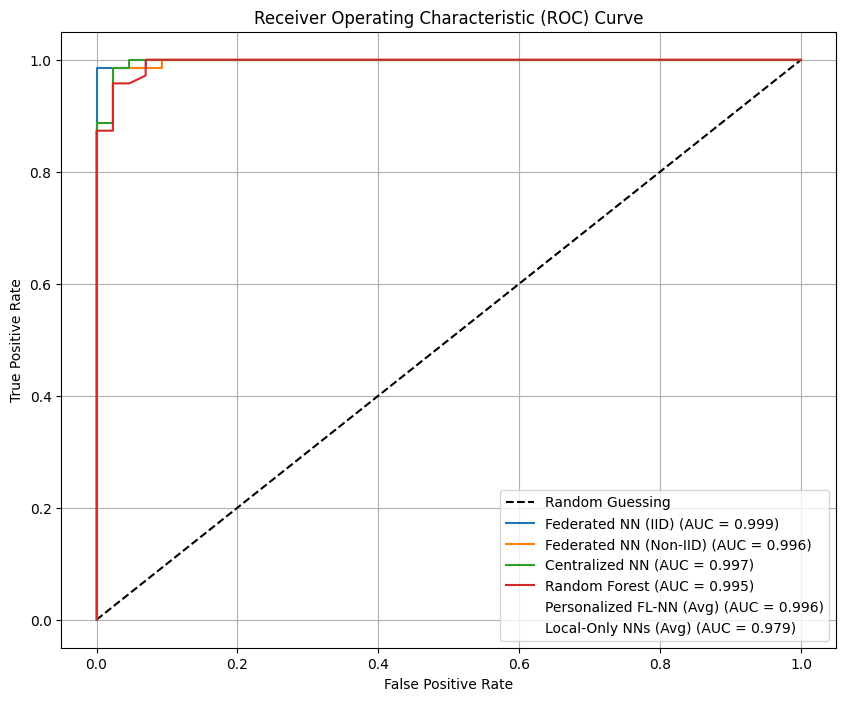

ROC curve generation complete.


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

print("Generating ROC curves...")

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

models_to_plot_roc = {
    'Federated NN (IID)': global_model_iid,
    'Federated NN (Non-IID)': global_model_non_iid,
    'Centralized NN': centralized_nn,
    'Random Forest': random_forest
}

# Plot ROC curves for individual models
for model_name, model in models_to_plot_roc.items():
    if model_name == 'Random Forest':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict(X_test).flatten()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

if 'Personalized FL-NN (Avg)' in updated_performance_table_with_roc_auc.index:
    avg_personalized_roc_auc = updated_performance_table_with_roc_auc.loc['Personalized FL-NN (Avg)', 'roc_auc']
    plt.plot([], [], ' ', label=f'Personalized FL-NN (Avg) (AUC = {avg_personalized_roc_auc:.3f})')

if 'Local-Only NNs (Avg)' in updated_performance_table_with_roc_auc.index:
    avg_local_only_roc_auc = updated_performance_table_with_roc_auc.loc['Local-Only NNs (Avg)', 'roc_auc']
    plt.plot([], [], ' ', label=f'Local-Only NNs (Avg) (AUC = {avg_local_only_roc_auc:.3f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("ROC curve generation complete.")